In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import importlib
from mpl_toolkits.mplot3d import Axes3D
import methods as met


importlib.reload(met)

<module 'methods' from 'c:\\Users\\Philipp\\Desktop\\StatML project\\stml-covariate-shift\\codes\\methods.py'>

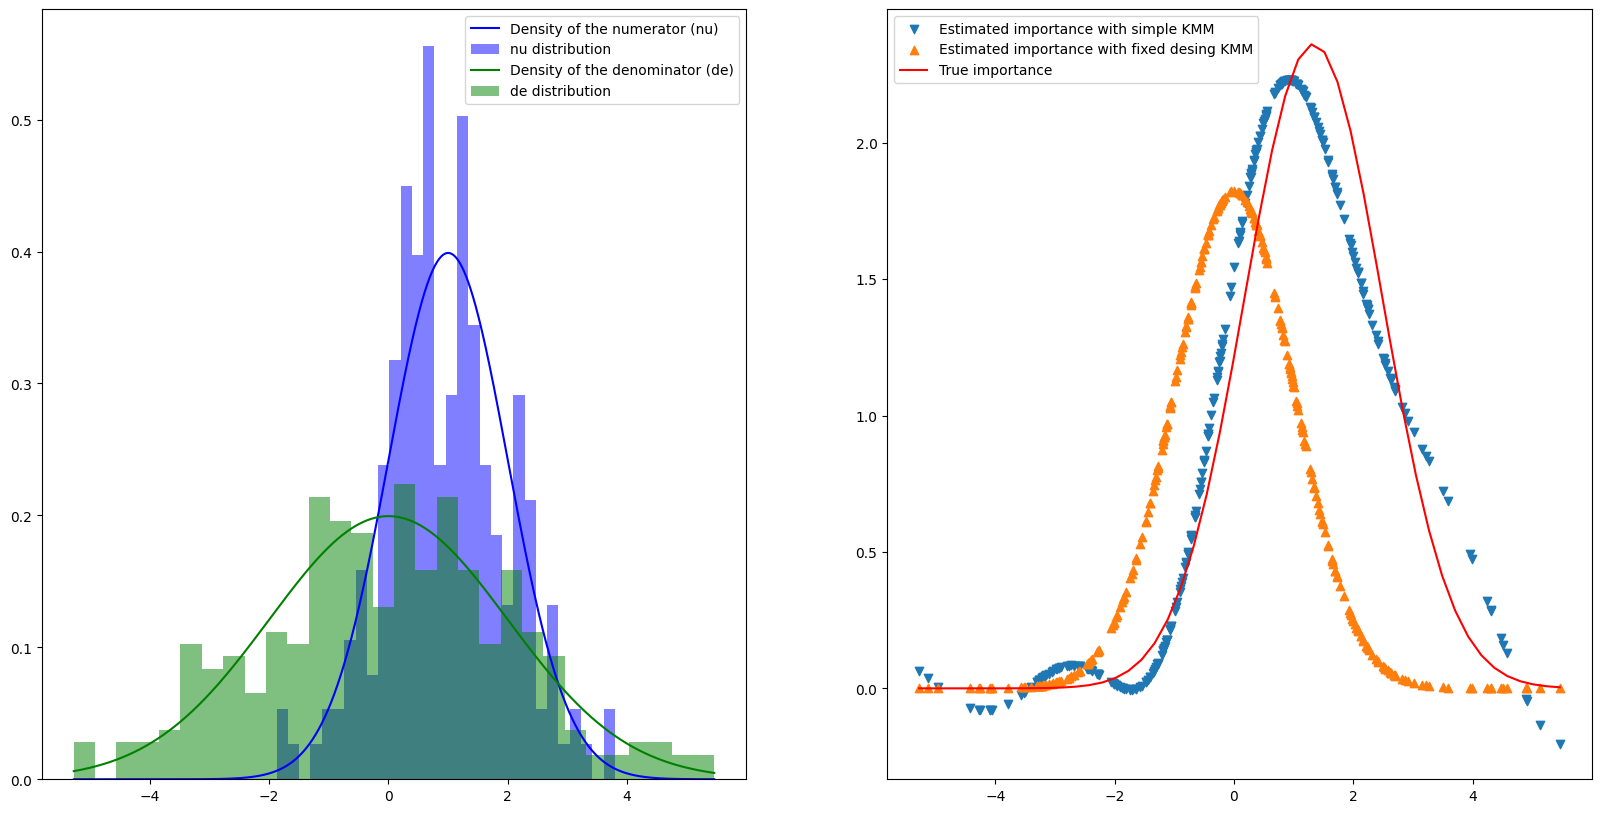

In [4]:
plot_precision = 1000




n_nu = 200
n_de = 300
#np.random.seed(1)
mu_nu, sigma_nu = 1, 1
mu_de, sigma_de = 0, 2

nu_data = np.random.normal(loc = mu_nu, scale = sigma_nu, size = n_nu)
de_data = np.random.normal(loc = mu_de, scale = sigma_de, size = n_de)

f_nu = lambda x: 1/np.sqrt(2*np.pi*sigma_nu**2)*np.exp(-(x - mu_nu)**2/(2*sigma_nu**2))
f_de = lambda x: 1/np.sqrt(2*np.pi*sigma_de**2)*np.exp(-(x - mu_de)**2/(2*sigma_de**2))

w = lambda x: f_nu(x)/f_de(x)

#x = np.linspace(-5,5, plot_precision)

tmp_nu = list(nu_data)
tmp_de = list(de_data)

n_nu = len(nu_data)
n_de = len(de_data)
l = []


for i in range(n_nu):
    for j in range(n_de):
        l.append(np.linalg.norm(nu_data[i]- de_data[j]))

#combined = sorted(tmp_nu + tmp_de) 
l = sorted(l)
sigma = np.median(l)


K = lambda x,y: np.exp(-(x-y)**2/(2*sigma**2))
r = met.KMM_simple(de_data, nu_data, K)

phi = lambda x: np.exp(-x**2/2)
r_2 = met.KMM_fixed_design(phi, de_data, nu_data)

x = np.linspace(min(min(de_data), min(nu_data)), max(max(de_data), max(nu_data)), plot_precision)
x2 = np.linspace(min(de_data), max(de_data))

_, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(x, f_nu(x), label = "Density of the numerator (nu)", color = "blue")
ax[0].hist(nu_data, density = True, color = "blue", label = "nu distribution", alpha = 0.5, bins = 30)
ax[0].plot(x, f_de(x), label = "Density of the denominator (de)", color = "green")
ax[0].hist(de_data, density = True, color = "green", label = "de distribution", bins = 30, alpha = 0.5)
#ax[0].plot(x, w(x), label = "Importance", color = "red")
ax[0].legend()
ax[1].scatter(de_data, r, label = "Estimated importance with simple KMM", marker = "v")
ax[1].scatter(de_data, r_2, label = "Estimated importance with fixed desing KMM", marker = "^")
ax[1].plot(x2, w(x2), label = "True importance", color = "red")
ax[1].legend()



IWCV

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3513933208355572
        x: [ 1.041e-01  8.023e-01  1.034e+00]
      nit: 9
      jac: [-8.009e-07 -5.376e-06 -6.493e-06]
 hess_inv: [[ 8.562e-01 -4.015e-01  1.423e-01]
            [-4.015e-01  3.994e-01 -1.546e-01]
            [ 1.423e-01 -1.546e-01  6.714e-02]]
     nfev: 48
     njev: 12


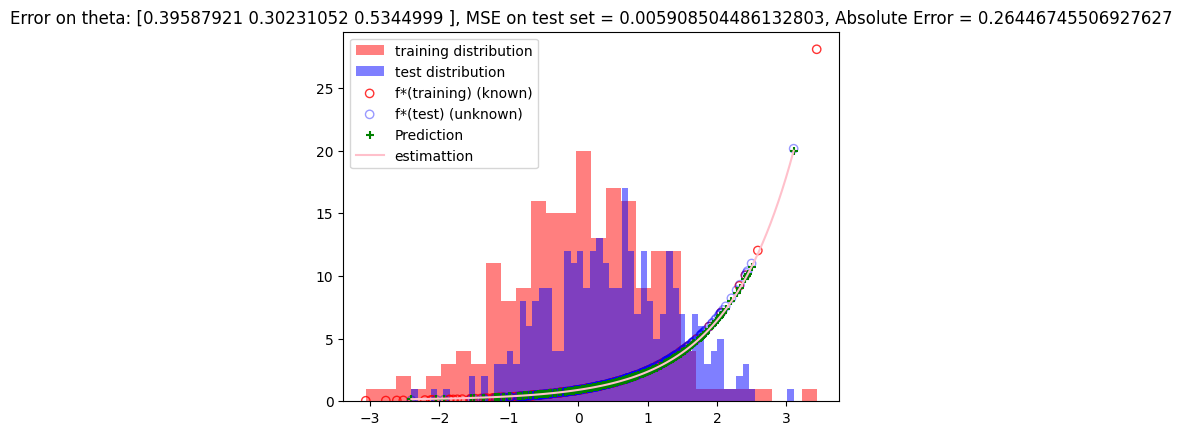

In [ ]:
true_f = lambda x: np.exp(x-0.1)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = -0.5, 1
mu_te, sigma_te = 1/2, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
#x_tr = -np.random.exponential(mu_tr, n_tr)
#x_tr = np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

plt.hist(x_tr, bins = 30, color = "r", label = "training distribution", alpha = 0.5)
plt.hist(x_te, bins = 60, color = "b", label = "test distribution", alpha = 0.5)
plt.scatter(x_tr, y_tr, facecolors = 'none', edgecolors = 'r', label = "f*(training) (known)", alpha = 0.8)
plt.scatter(x_te, y_te, facecolors = 'none', edgecolors = 'b', label = "f*(test) (unknown)", alpha = 0.4)

#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
perturbation = 0.5
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)
dim_theta = 3
#dimension_of_parameter = n_te
#theta = np.zeros((1, n_te))
#f = lambda x, theta: np.sum([theta[i] * K(x, x_te[i]) for i in range(n_te)])

#f = lambda x, theta: x*theta
L = lambda x,y: np.linalg.norm(x-y)**2

#theta_opti = met.IWCV(f, dimension_of_parameter, L, x_te, training_set, 0.5, 0.2)
theta_opti, f_opti = met.IWCV(f, dim_theta, L, x_te, training_set, 0.5, 0.2)


#f_opti = lambda x: f(x, theta_opti)
#print(theta_opti)
plt.scatter(x_te, f_opti(x_te), label ="Prediction", color = "green", marker = "+")
y_2 = np.linspace(min(x_te), max(x_te),100)
plt.plot(y_2, f_opti(y_2), color = "pink", label ="estimattion")


#Compute MSE on test set:
avg_MSE_test = np.linalg.norm(f_opti(x_te) - y_te) / n_te
AE = max(np.abs(f_opti(x_te) - y_te))

plt.title(f"Error on theta: {np.abs(theta_opti - perturbation)}, MSE on test set = {avg_MSE_test}, Absolute Error = {AE}")
plt.legend()

#textbox = '\n'.join([
#    f"Error on theta: {np.abs(theta_opti - perturbation)}",
#    f"MSE on test set: {avg_MSE_test}",
#    f"Absolute Error = {AE}"
#])

# Define the properties for the bounding box (fixing the key name)
#bbox_ = dict(boxstyle = "square", facecolor = "gray", alpha = 1)#0.5)

# Adding the text directly to the default figure
#plt.text(0.5, 0.9, textbox, fontsize = 10, bbox = bbox_, verticalalignment = "top")#, ha="right")


Don't actually need to do this or what?

In [7]:
precision = 10
zero_minimum =0
gamma_range = np.linspace(zero_minimum, 1, precision)
lambda_range = np.linspace(zero_minimum, 1, precision)

true_f = lambda x: np.exp(x)
perturbation = 0.5
f = lambda x, theta: (x- theta)**2


n_tr, n_te = 200, 200

mu_tr, sigma_tr = 1, 1
mu_te, sigma_te = 3, 1.1

x_tr = -np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr, y_te = true_f(x_tr), true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

MSE_matrix = np.zeros((precision, precision))

for i in range(precision):
    for j in range(precision):
        theta_opti = met.IWCV(f, 1, L, x_te, training_set, gamma_range[i], lambda_range[i])
        f_theta = lambda x: f(x, theta_opti)
        tmp = np.linalg.norm(f_theta(x_te)-y_te)
        
        MSE_matrix[i, j] = tmp/n_te
                        


fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(gamma_range, lambda_range)
surf = ax.plot_surface(X, Y, MSE_matrix, cmap='viridis', edgecolor='none') 
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('Tested flattening parameters (gamma)')
ax.set_ylabel('Tested regularization parameters (lambda)')
ax.set_zlabel('MSE given (gamma, lambda)')
ax.set_title(f"MSE given flatteing and regularization parameters. Minimum is {np.min(MSE_matrix)}")
plt.show()


min_index = np.argmin(MSE_matrix)  
gamma_opti_arg, lambda_opti_arg = np.unravel_index(min_index, MSE_matrix.shape)
gamma_opti, lambda_opti = gamma_range[gamma_opti_arg], lambda_range[lambda_opti_arg]

print(f"Estimated flattening and regularization parameters that achieve (approx.) minimum on the generalization error: ({gamma_opti}, {lambda_opti})")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.276022532755951
        x: [-1.804e+00]
      nit: 8
      jac: [ 1.192e-07]
 hess_inv: [[ 5.214e-02]]
     nfev: 18
     njev: 9


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Regularizations paths and evolution of the IWCV

In [8]:
true_f = lambda x: np.exp(x+5)

n_tr = 200
n_te = 300

mu_tr, sigma_tr = 1/2, 1
mu_te, sigma_te = 0, 1

x_tr = np.random.normal(loc = mu_tr, scale = sigma_tr**2, size = n_tr)
#x_tr = -np.random.exponential(mu_tr, n_tr)
#x_tr = np.random.exponential(mu_tr, n_tr)
x_te = np.random.normal(loc = mu_te, scale = sigma_te**2, size = n_te)

y_tr = true_f(x_tr)
y_te = true_f(x_te)

training_set = np.zeros((2, n_tr))
training_set[0, :], training_set[1, :] = x_tr, y_tr

#plt.hist(x_tr, bins = 30, color = "r", label = "training distribution", alpha = 0.5)
#plt.hist(x_te, bins = 60, color = "b", label = "test distribution", alpha = 0.5)
#plt.scatter(x_tr, y_tr, facecolors = 'none', edgecolors = 'r', label = "f*(training) (known)", alpha = 0.8)
#plt.scatter(x_te, y_te, facecolors = 'none', edgecolors = 'b', label = "f*(test) (unknown)", alpha = 0.4)

#f = lambda x, theta: (1 / (np.sqrt(2 * np.pi * theta[1]**2))) * np.exp(-((x - theta[0])**2) / (2 * theta[1]**2))
perturbation = 0.5
#f = lambda x, theta: (x- theta + perturbation)**2
#f = lambda x, theta: theta[0] + theta[1]*np.cos(x*theta[2])
f = lambda x, theta: theta[0] + theta[1]*np.exp(theta[2]*x)
dim_theta = 3
#dimension_of_parameter = n_te
#theta = np.zeros((1, n_te))
#f = lambda x, theta: np.sum([theta[i] * K(x, x_te[i]) for i in range(n_te)])

#f = lambda x, theta: x*theta
L = lambda x,y: np.linalg.norm(x-y)**2

params_variation_size = 20
lambda_grid = np.linspace(0,1, params_variation_size)
gamma_grid = np.linspace(0,1, params_variation_size)

#theta_opti, f_opti = met.IWCV(f, dim_theta, L, x_te, training_set, 0.5, 0.2)

#grid_search = np.zeros((len(gamma_grid), len(lambda_grid)))

grid_search = np.empty((len(gamma_grid), len(lambda_grid)), dtype=object)


for i in range(len(gamma_grid)):
    for j in range(len(lambda_grid)):
        tmp, _ = met.IWCV(f, dim_theta, L, x_te, training_set, gamma_grid[i], lambda_grid[j])
        print("ici: ", tmp)
        grid_search[i, j] = tmp

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.legend()

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.2237177366896359e-09
        x: [-7.741e-05  1.484e+02  1.000e+00]
      nit: 35
      jac: [ 2.161e-06  2.961e-05  1.320e-02]
 hess_inv: [[ 3.249e+00 -2.105e+00  5.196e-03]
            [-2.105e+00  1.695e+00 -4.408e-03]
            [ 5.196e-03 -4.408e-03  1.202e-05]]
     nfev: 332
     njev: 80
ici:  [-7.74053141e-05  1.48413223e+02  9.99999830e-01]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1025.7236211892102
        x: [ 1.952e+01  1.320e+02  1.046e+00]
      nit: 43
      jac: [ 0.000e+00  6.104e-05  9.003e-04]
 hess_inv: [[ 2.866e-07  1.346e-07 -5.615e-07]
            [ 1.346e-07  4.099e-07 -2.740e-07]
            [-5.615e-07 -2.740e-07  1.131e-06]]
     nfev: 518
     njev: 125
ici:  [ 19.5171906  131.95693876   1.04576651]
  message: Desired error not necessarily achieved due to precision loss.

In [9]:
print(gamma_grid.shape, lambda_grid.shape, grid_search.shape)
print(grid_search)
print(gamma_grid)
print(lambda_grid)

(20,) (20,) (20, 20)
[[array([-7.74053141e-05,  1.48413223e+02,  9.99999830e-01])
  array([ 19.5171906 , 131.95693876,   1.04576651])
  array([ 27.87989066, 123.72650582,   1.0714731 ])
  array([ 32.40953233, 118.29388498,   1.08978525])
  array([ 35.10152122, 114.23034962,   1.10429555])
  array([ 36.76556837, 110.96492764,   1.11650648])
  array([ 37.79973636, 108.21767964,   1.12717922])
  array([ 38.42382349, 105.83307735,   1.13674725])
  array([ 38.76955813, 103.71643761,   1.14548011])
  array([ 38.92042849, 101.80636797,   1.15355564])
  array([ 38.9318009 , 100.06090043,   1.16109729])
  array([38.84169992, 98.45015364,  1.1681942 ])
  array([38.67698831, 96.95205906,  1.17491309])
  array([38.45695991, 95.54994921,  1.18130488])
  array([38.19602998, 94.23073711,  1.18741009])
  array([37.90473176, 92.98412526,  1.19326096])
  array([37.59119985, 91.80177503,  1.19888373])
  array([37.26154633, 90.67685841,  1.20430017])
  array([36.92056022, 89.60356331,  1.2095291 ])
  arra

<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Philipp\AppData\Local\Temp\ipykernel_11352\1532902781.py:25: SyntaxWarning: invalid escape sequence '\g'
  ax.set(xlabel=('$\gamma$'), ylabel=('$\lambda$'), zlabel=('θ$_i$'))
C:\Users\Philipp\AppData\Local\Temp\ipykernel_11352\1532902781.py:25: SyntaxWarning: invalid escape sequence '\l'
  ax.set(xlabel=('$\gamma$'), ylabel=('$\lambda$'), zlabel=('θ$_i$'))


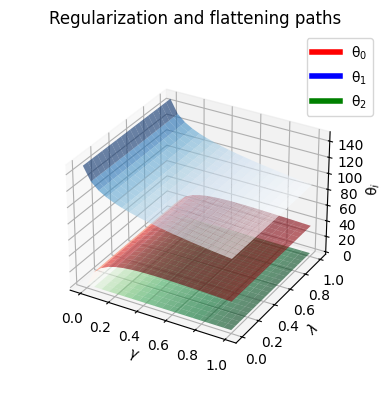

In [20]:
# print(grid_search)
theta_0 = [[x[0].item() for x in result] for result in grid_search]
theta_1 = [[x[1].item() for x in result] for result in grid_search]
theta_2 = [[x[2].item() for x in result] for result in grid_search]
Z0 = np.array([val for sublist in theta_0 for val in sublist]).reshape(20,20)
Z1 = np.array([val for sublist in theta_1 for val in sublist]).reshape(20,20)
Z2 = np.array([val for sublist in theta_2 for val in sublist]).reshape(20,20)

matplotlib.rcParams['legend.fontsize'] = 10


plotx,ploty = np.meshgrid(gamma_grid,lambda_grid)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(plotx,ploty, Z0, alpha=0.6, cmap='Reds', label='θ$_0$')
ax.plot_surface(plotx,ploty, Z1, alpha=0.6, cmap='Blues', label='theta1')
ax.plot_surface(plotx,ploty, Z2, alpha=0.6, cmap='Greens', label='theta2')

red_patch = plt.Line2D([0], [0], color='red', lw=4, label='θ$_0$')
blue_patch = plt.Line2D([0], [0], color='blue', lw=4, label='θ$_1$')
green_patch = plt.Line2D([0], [0], color='green', lw=4, label='θ$_2$')

ax.set(xlabel=('$\gamma$'), ylabel=('$\lambda$'), zlabel=('θ$_i$'))
ax.set_title("Regularization and flattening paths")
ax.legend(handles=[red_patch, blue_patch, green_patch])
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()